# 신용카드_신용_예측
### 사용자의 대금 연체 정도를 예측하기

In [1]:
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np


from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus = False)

# 1. 파일 불러오기

In [2]:
df_test = pd.read_csv("./open/test.csv", engine='python',encoding='CP949')
df_train = pd.read_csv("./open/train.csv", engine='python',encoding='CP949')
df_train = df_train.set_index("index")

# 2. 데이터 전처리

In [3]:
df_train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [4]:
del df_train['occyp_type']

In [5]:
df_train['car'] = df_train['car'].replace(['N','Y'],[0,1])
df_train['reality'] = df_train['reality'].replace(['N','Y'],[0,1])
df_train['gender'] = df_train['gender'].replace(['F','M'],[0,1])

#### FLAG_MOBIL 은 모두 1 , 가지고 있으므로 제거

In [6]:
df_train = df_train.drop('FLAG_MOBIL', axis=1)
df_train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,4.0,-2.0,1.0
26453,0,0,1,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,0,0,0,2.0,-47.0,2.0
26454,0,1,0,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,2.0,-25.0,2.0


#  3. 텍스트와 범주형 특성 다루기
## 1) One- Hot encoding

###### - 텍스트에서 숫자로 매핑해주는 factorize()

In [7]:
income = df_train['income_type']
income_encoded, income_categories = income.factorize()

edu = df_train['edu_type']
edu_encoded, edu_categories = edu.factorize()

family = df_train['family_type']
family_encoded, family_categories = family.factorize()

house = df_train['house_type']
house_encoded, house_categories = house.factorize()

#### - dummies를 통해 인코딩
##### income_type, edu_type, family_type, house_type의 categories 포함 인코딩

In [8]:
df_train = pd.get_dummies(data = df_train, columns = ['income_type'], prefix = 'income_type', dummy_na = True)
df_train = pd.get_dummies(data = df_train, columns = ['edu_type'], prefix = 'edu_type', dummy_na = True)
df_train = pd.get_dummies(data = df_train, columns = ['family_type'], prefix = 'family_type', dummy_na = True)
df_train = pd.get_dummies(data = df_train, columns = ['house_type'], prefix = 'house_type', dummy_na = True)

In [9]:
df_train = df_train.drop(['income_type_nan','edu_type_nan', 'family_type_nan', 'house_type_nan'],axis = 1)
df_train

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,202500.0,-13899,-4709,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,1,1,247500.0,-11380,-1540,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,450000.0,-19087,-4434,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,202500.0,-15088,-2092,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,1,1,0,157500.0,-15037,-2105,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,225000.0,-12079,-1984,0,0,0,...,1,0,0,0,0,1,0,0,0,0
26453,0,0,1,1,180000.0,-15291,-2475,0,0,0,...,0,1,0,0,0,1,0,0,0,0
26454,0,1,0,0,292500.0,-10082,-2015,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
y_train = df_train['credit']
del df_train['credit']

In [11]:
y_train= y_train.astype(int)
y_train

index
0        1
1        1
2        2
3        0
4        2
        ..
26452    1
26453    2
26454    2
26455    2
26456    2
Name: credit, Length: 26457, dtype: int32

# 5. 스케일링
### - Min-Max 스케일링은 특징의 최소값과 최대값을 먼저 계산하고 전체 특징값들을 0~1 사이의 값으로 변경
### - 표준화는 먼저 평균과 표준편차를 구하고 전체 데이터 각각에 대해 평균을 뺀 후
### 표준편차로 나눠 분산이 1이 되도록 데이터를 조정

##### 1) Min-Max

In [12]:
df_train1 = df_train.copy()

In [13]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

In [14]:
df_train = minmax_scaler.fit_transform(df_train)
df_train = pd.DataFrame(df_train)
df_train.columns = df_train1.columns 

In [15]:
df_train

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0.0,0.0,0.0,0.000000,0.113372,0.644982,0.028885,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.052632,0.142442,0.789362,0.037204,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.000000,0.273256,0.347624,0.029607,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.000000,0.113372,0.576833,0.035755,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.000000,0.084302,0.579756,0.035721,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.0,0.0,0.0,0.105263,0.127907,0.749298,0.036038,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26453,0.0,0.0,1.0,0.052632,0.098837,0.565197,0.034749,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,0.0,1.0,0.0,0.000000,0.171512,0.863759,0.035957,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26455,1.0,0.0,1.0,0.000000,0.093023,0.860148,0.040965,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### 2) 표준화

In [16]:
df_train1 = (df_train1- df_train1.mean())/df_train1.std()

In [17]:
df_train1

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
index,,,,,,,,,,,,,,,,,,,,,
0,-0.703548,-0.782448,-1.437598,-0.573588,0.149133,0.490066,-0.463921,-0.538407,-0.645692,-0.316931,...,0.673783,-0.248516,-0.390195,-0.208572,-0.064613,-2.904330,5.598423,-0.085048,-0.128381,-0.223336
1,-0.703548,-0.782448,0.695578,0.764515,0.590837,1.089601,-0.440870,-0.538407,-0.645692,3.155139,...,-1.484101,-0.248516,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
2,1.421312,1.277991,0.695578,-0.573588,2.578501,-0.744705,-0.461921,-0.538407,1.548666,-0.316931,...,0.673783,-0.248516,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
3,-0.703548,-0.782448,0.695578,-0.573588,0.149133,0.207077,-0.444885,-0.538407,1.548666,-0.316931,...,0.673783,-0.248516,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
4,-0.703548,1.277991,0.695578,-0.573588,-0.292570,0.219216,-0.444980,-0.538407,-0.645692,-0.316931,...,0.673783,-0.248516,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.703548,-0.782448,-1.437598,2.102618,0.369985,0.923235,-0.444099,-0.538407,-0.645692,-0.316931,...,0.673783,-0.248516,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
26453,-0.703548,-0.782448,0.695578,0.764515,-0.071718,0.158762,-0.447671,-0.538407,-0.645692,-0.316931,...,-1.484101,4.023732,-0.390195,-0.208572,-0.064613,0.344301,-0.178615,-0.085048,-0.128381,-0.223336
26454,-0.703548,1.277991,-1.437598,-0.573588,1.032540,1.398531,-0.444325,-0.538407,-0.645692,-0.316931,...,-1.484101,-0.248516,-0.390195,-0.208572,-0.064613,-2.904330,-0.178615,-0.085048,-0.128381,4.477385


# 6. 교차 검증을 사용한 평가

### - y_train one-hot-encoding

In [18]:
y_train1 = y_train.copy()

In [19]:
y_train1

index
0        1
1        1
2        2
3        0
4        2
        ..
26452    1
26453    2
26454    2
26455    2
26456    2
Name: credit, Length: 26457, dtype: int32

In [20]:
y_train_dummies = pd.get_dummies(data = y_train1)

In [21]:
y_train_dummies

,0,1,2
index,,,
0,0,1,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
26452,0,1,0
26453,0,0,1
26454,0,0,1


In [22]:
y_train_dummies.columns=['y_train_0', 'y_train_1' ,'y_train_2']

In [23]:
y_train_dummies

,y_train_0,y_train_1,y_train_2
index,,,
0,0,1,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
26452,0,1,0
26453,0,0,1
26454,0,0,1


In [24]:
df_heatmap = pd.concat([y_train_dummies, df_train], axis = 1)

In [25]:
df_heatmap

,y_train_0,y_train_1,y_train_2,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,0,1,0,0.0,0.0,0.0,0.000000,0.113372,0.644982,0.028885,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,0,0.0,0.0,1.0,0.052632,0.142442,0.789362,0.037204,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0,1,1.0,1.0,1.0,0.000000,0.273256,0.347624,0.029607,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,0,0.0,0.0,1.0,0.000000,0.113372,0.576833,0.035755,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,1,0.0,1.0,1.0,0.000000,0.084302,0.579756,0.035721,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,1,0,0.0,0.0,0.0,0.105263,0.127907,0.749298,0.036038,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26453,0,0,1,0.0,0.0,1.0,0.052632,0.098837,0.565197,0.034749,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,0,0,1,0.0,1.0,0.0,0.000000,0.171512,0.863759,0.035957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26455,0,0,1,1.0,0.0,1.0,0.000000,0.093023,0.860148,0.040965,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


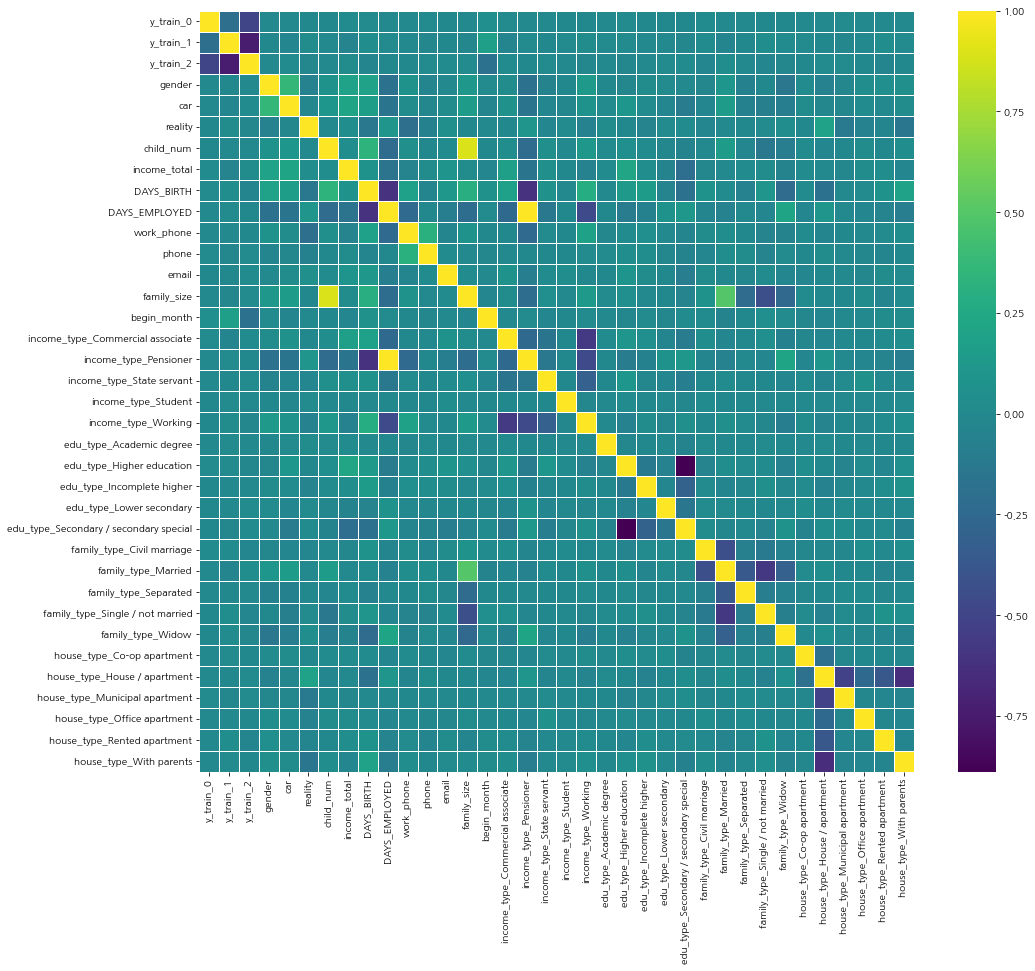

In [26]:
plt.figure(figsize=(16,14))
sns.heatmap(df_heatmap.corr(),  linewidths=0.5,  cmap='viridis')
plt.show()

## - K-Fold Cross-Validation

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
df_train_kfold = df_train.values

In [29]:
from sklearn.model_selection import cross_val_score

result = cross_val_score(RandomForestClassifier(), df_train_kfold, y_train1, scoring="accuracy", cv=6)
result.mean()

0.7027249800149389

## - DecisionTre

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_train, y_train1)

DecisionTreeRegressor()

In [31]:
from sklearn.metrics import mean_squared_error
housing_predictions = tree_reg.predict(df_train)
tree_mse = mean_squared_error(y_train1, housing_predictions)
tree_rmse1 = np.sqrt(tree_mse)
print('RMSE :', tree_rmse1)

RMSE : 0.1692061882651832


# 7. 훈련세트에서 훈련, 평가

### RMSE (Root Mean Squared Error)
#### - 제곱된 에러를 다시 루트로 풀어주기 때문에 에러를 제곱해서 생기는 값의 왜곡이 좀 덜하다
#### - RMSE 예측오차 값이 작을수록 더 정확한 모형
### Random forest
#### - 여러개의 decision tree를 형성하고 새로운 데이터 포인트를 각 트리에 동시에 통과
#### - 각 트리가 분류한 결과에서 투표를 실시하여 가장 많이 득표한 결과를 최종 분류 결과로 선택
### log_loss
#### - 분류 모델의 손실 함수로 사용되며 Cross Entropy라고도 불림
#### - log_loss는 정확한 label값 (0, 1, ..)을 맞히는 것이 아닌, 모델이 그 클래스를 예측할 확률을 이용해서 평가하는 지표

In [32]:
from subprocess import check_output
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

#### 1) 나눴을 때

In [33]:
x_t, x_v, y_t, y_v = train_test_split(df_train, y_train, test_size=0.2, random_state=42)

In [34]:
print(len(x_t), len(y_t))
print(len(x_v), len(y_v))

21165 21165
5292 5292


In [35]:
clf_part = RandomForestClassifier(n_estimators=200)
clf_part.fit(x_t, y_t)

RandomForestClassifier(n_estimators=200)

In [36]:
probs = clf_part.predict_proba(x_v)
print(probs)

[[0.02       0.59       0.39      ]
 [0.05509524 0.51440476 0.4305    ]
 [0.105      0.228      0.667     ]
 ...
 [0.005      0.0175     0.9775    ]
 [0.090625   0.165      0.744375  ]
 [0.025      0.285      0.69      ]]


In [37]:
logLoss = log_loss(y_v, probs)
print(logLoss)

0.8486818899948402


#### 2) 전체

In [38]:
clf_all = RandomForestClassifier(n_estimators = 200)
clf_all.fit(df_train, y_train)

RandomForestClassifier(n_estimators=200)

In [39]:
probs = clf_all.predict_proba(x_v)
print(probs)

[[0.         0.245      0.755     ]
 [0.03625    0.80083333 0.16291667]
 [0.04083333 0.07166667 0.8875    ]
 ...
 [0.01       0.015      0.975     ]
 [0.015      0.055      0.93      ]
 [0.005      0.045      0.95      ]]


In [40]:
logLoss = log_loss(y_v, probs)
print(logLoss)

0.18094378473220615


###  add tuning

In [41]:
from sklearn.model_selection import GridSearchCV
forest_params = {'max_depth': range(5, 15), 'max_features': ['auto', 'sqrt', 'log2']}

In [364]:
# 그리드 서치 적용
locally_best_forest = GridSearchCV(RandomForestClassifier(n_estimators=20, random_state=17, n_jobs=-1),forest_params, cv=3, verbose=1)
locally_best_forest.fit(x_t, y_t)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=20, n_jobs=-1,
                                              random_state=17),
             param_grid={'max_depth': range(5, 15),
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

In [365]:
print("Best params:", locally_best_forest.best_params_)

Best params: {'max_depth': 14, 'max_features': 'auto'}


In [366]:
print("Best cross validaton score", locally_best_forest.best_score_)

Best cross validaton score 0.6982282069454288


# 8. Test dataset 가공 및 테스트
#### - 위 train과 가공 방법 같음

In [42]:
df_test = df_test.set_index("index")
del df_test['occyp_type']

In [43]:
df_test['car'] = df_test['car'].replace(['N','Y'],[0,1])
df_test['reality'] = df_test['reality'].replace(['N','Y'],[0,1])
df_test['gender'] = df_test['gender'].replace(['F','M'],[0,1])
df_test = df_test.drop('FLAG_MOBIL', axis=1)

In [44]:
income = df_test['income_type']
income_encoded, income_categories = income.factorize()

edu = df_test['edu_type']
edu_encoded, edu_categories = edu.factorize()

family = df_test['family_type']
family_encoded, family_categories = family.factorize()

house = df_test['house_type']
house_encoded, house_categories = house.factorize()

In [45]:
df_test = pd.get_dummies(data = df_test, columns = ['income_type'], prefix = 'income_type', dummy_na = True)
df_test = pd.get_dummies(data = df_test, columns = ['edu_type'], prefix = 'edu_type', dummy_na = True)
df_test = pd.get_dummies(data = df_test, columns = ['family_type'], prefix = 'family_type', dummy_na = True)
df_test = pd.get_dummies(data = df_test, columns = ['house_type'], prefix = 'house_type', dummy_na = True)

In [46]:
df_test = df_test.drop(['income_type_nan','edu_type_nan', 'family_type_nan', 'house_type_nan'],axis = 1)

In [47]:
df_test1 = df_test.copy()

In [48]:
minmax_scaler = MinMaxScaler()

In [49]:
df_test = minmax_scaler.fit_transform(df_test)
df_test = pd.DataFrame(df_test)

In [50]:
df_test.columns = df_test1.columns

In [51]:
df_test

,gender,car,reality,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,1.0,1.0,0.0,0.0,0.055233,0.179018,1.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.069767,0.350337,0.018351,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.027372,0.524543,0.040546,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.055233,0.333013,0.034471,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.127907,0.414992,0.016477,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.0,0.0,0.113372,0.371341,0.026849,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9996,1.0,1.0,1.0,0.0,0.113372,0.807677,0.037663,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,1.0,0.0,0.171512,0.234162,0.004313,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,0.0,1.0,0.0,0.0,0.098837,0.487516,0.038267,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
len(df_test)

10000

In [53]:
probs_test = clf_all.predict_proba(df_test)
final_probs = pd.DataFrame(probs_test)

In [54]:
final_probs

,0,1,2
0,0.035000,0.205833,0.759167
1,0.355000,0.215000,0.430000
2,0.080000,0.145000,0.775000
3,0.070750,0.065000,0.864250
4,0.112500,0.210000,0.677500
...,...,...,...
9995,0.103333,0.206667,0.690000
9996,0.145000,0.432500,0.422500
9997,0.060000,0.105000,0.835000
9998,0.365000,0.193333,0.441667


In [55]:
submit = pd.read_csv('open/sample_submission.csv')

In [56]:
submit.iloc[:,1:]=0
submit.iloc[:,1:] = final_probs

In [57]:
submit.to_csv('open/test_sample_submission.csv', index=False) 

In [58]:
submit.head()

,index,0,1,2
0,26457,0.03500,0.205833,0.759167
1,26458,0.35500,0.215000,0.430000
2,26459,0.08000,0.145000,0.775000
3,26460,0.07075,0.065000,0.864250
4,26461,0.11250,0.210000,0.677500
